<a href="https://colab.research.google.com/github/KenObata/Music4All_personal_project/blob/main/week7_lang_ingnored_clf_vs_lang_specific.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Week7: The goal of this notebook is to experiment if language specific trained classifier is better than language ignored genre detection.

### Data preparation

In [1]:
#Check RAM size. If small, you can upgrade.
#you can enable a high-RAM runtime via Runtime > Change runtime type in the menu
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from collections import Counter

from skmultilearn.model_selection import IterativeStratification   
from sklearn.model_selection import StratifiedKFold
from scipy.sparse import csr_matrix
plt.style.use('seaborn')

CSV_FOLDER = 'drive/MyDrive/music4all/'
LANG_DIR = 'drive/MyDrive/music4all/split-language_only-artist_grouped'
SPLIT_DIR = 'drive/MyDrive/music4all/split-all_labels'
FIG_DIR = 'drive/MyDrive/music4all/figures'

font = {'size': 22}

matplotlib.rc('font', **font)

scikit-multilearn has to be installed from pip
https://github.com/scikit-multilearn/scikit-multilearn/issues/142

In [4]:
def write_txt(path, list_of_str):
    with open(path, 'w') as f:
        for value in list_of_str:
            f.write(value)
            f.write('\n')

In [5]:
def analyze_genre_tag_df(df, top_n=100):
    """plot the occurrences of top_n items in the given df"""
    def get_counter(items: list):
        """items: list of list"""    
        items = [g.split(',') for g in items]
        items = [item for sublist in items for item in sublist]
        items = Counter(items)    
        return items
    
    def plot_freqs(counter: Counter, top_n, title=''):
        most_common = counter.most_common(top_n)
        names, counts = list(zip(*most_common))

        xs = np.arange(len(names))
        plt.figure(figsize=(18, 7))
        plt.bar(xs, counts)
        plt.xticks(xs + 0.2, names, rotation=60, size=17, ha='right') 
        plt.title('Top-%d %s (out of %d in total)' % (top_n, title, len(counter)), size=20)
        plt.ylabel('occurrence', size=17)
        
    column_name = df.columns[1]
    labels = df[column_name].tolist()
    labels = get_counter(labels)
    
    print('Number of %s: %d' % (column_name, len(labels)))

    plot_freqs(labels, top_n=top_n, title=column_name)
    return labels
    
def analyze_genre_tag_csv(csv_path, top_n):
    """wrapper of analyze_genre_tag_df"""
    basename = os.path.basename(csv_path)
    df = pd.read_csv(os.path.join(CSV_FOLDER, csv_path), header=0, sep='	')
    df.head()
    return analyze_genre_tag_df(df, top_n=top_n)

id_genres.csv

Number of genres: 853
Counter({'rock': 25731, 'pop': 22013, 'electronic': 12769, 'alternative rock': 8103, 'indie rock': 7943, 'metal': 6459, 'folk': 6106, 'singer-songwriter': 5793, 'classic rock': 5688, 'soul': 5458, 'experimental': 4489, 'rap': 4414, 'indie pop': 4141, 'hard rock': 3855, 'punk': 3652, 'ambient': 3645, 'synthpop': 3034, 'post-hardcore': 2938, 'new wave': 2859, 'progressive rock': 2802, 'hardcore': 2790, 'mpb': 2700, 'jazz': 2641, 'emo': 2537, 'post-punk': 2485, 'soundtrack': 2473, 'hip hop': 2408, 'pop punk': 2223, 'metalcore': 2210, 'lo-fi': 2064, 'death metal': 2030, 'dream pop': 1963, 'progressive metal': 1945, 'pop rock': 1898, 'shoegaze': 1835, 'funk': 1814, 'country': 1786, 'k-pop': 1661, 'black metal': 1604, 'blues': 1559, 'latin': 1557, 'post-rock': 1530, 'electropop': 1423, 'house': 1412, 'psychedelic rock': 1322, 'thrash metal': 1257, 'industrial': 1247, 'grunge': 1193, 'electronica': 1178, 'britpop': 1170, 'gothic metal': 1169, 'doom metal': 1150, 'melodic

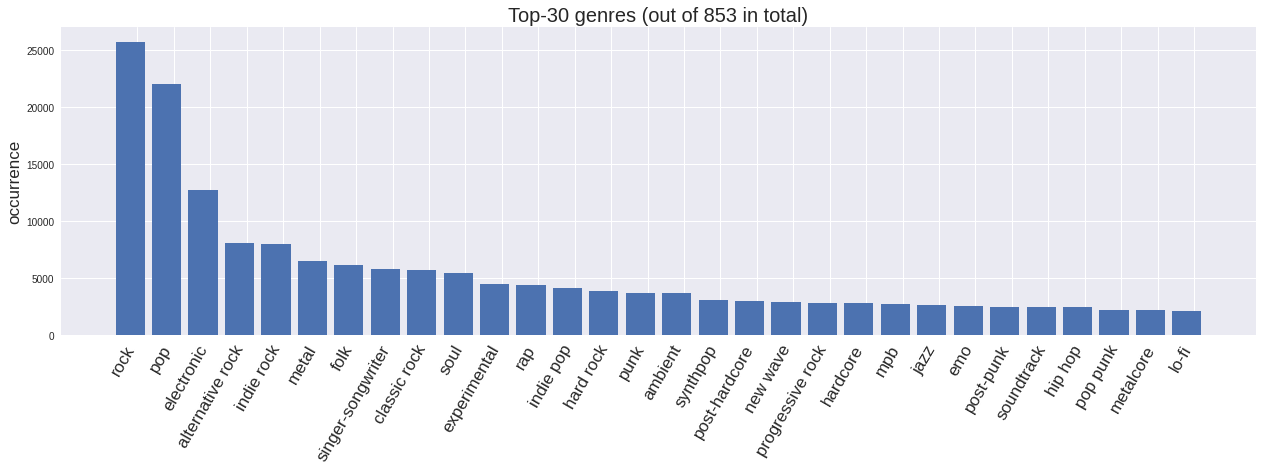

In [6]:
genre_counter = analyze_genre_tag_csv('id_genres.csv', top_n=30)
print(genre_counter)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'occurrence-genre.png'))

Create English dataframe (Clf2_en)

In [7]:
#fileter Eng
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_en=df_lang[ df_lang['lang'].isin(['en']) ]
df_lang_en

,id,lang
0,0009fFIM1eYThaPg,en
1,0010xmHR6UICBOYT,en
2,002Jyd0vN4HyCpqL,en
3,006TYKNjNxWjfKjy,en
4,007LIJOPQ4Sb98qV,en
...,...,...
109264,zzyyPUs7hC9Nz2e1,en
109265,zzz0n04uuTUA7fNh,en
109266,zzzj3LYaZtYtbzSr,en
109267,zzznMjZAKnJJXQSj,en


In [8]:
df_genres = pd.read_csv(os.path.join(CSV_FOLDER, 'id_genres.csv'), header=0, sep='	')

In [9]:
# merge en dataframes & genres into one
df_genre_en = pd.concat([df_genres['id'], df_genres['genres'], df_lang_en['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_en


,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,0010xmHR6UICBOYT,underground hip hop,en
2,002Jyd0vN4HyCpqL,"hard rock,rock,classic rock",en
3,006TYKNjNxWjfKjy,"symphonic metal,power metal,symphonic power metal",en
4,007LIJOPQ4Sb98qV,"post-punk,new wave",en
...,...,...,...
109264,zzyyPUs7hC9Nz2e1,"hardcore punk,punk,hardcore",en
109265,zzz0n04uuTUA7fNh,pop,en
109266,zzzj3LYaZtYtbzSr,singer-songwriter,en
109267,zzznMjZAKnJJXQSj,"synthpop,remix,pop",en


Number of genres: 671


['rock', 'pop', 'electronic', 'alternative rock', 'indie rock']

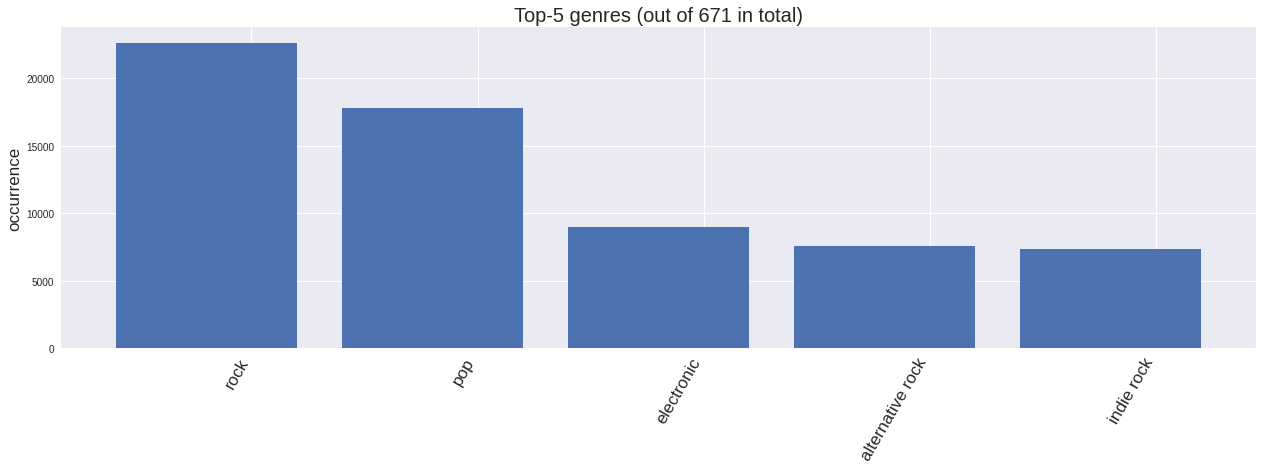

In [10]:

genre_counter = analyze_genre_tag_df(df_genre_en, top_n = 5)
plt.tight_layout()
genre_counter = sorted(genre_counter.items(), key=lambda item: item[1], reverse = True)
genre_counter_top_list = [genre for genre, count in genre_counter[:5] ]
genre_counter_top_list

In [11]:
df_genre_en = df_genre_en[df_genre_en['genres'].isin(genre_counter_top_list)]
df_genre_en

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
16,00b6fV3nx5z2b8Ls,pop,en
26,013QDoTqbexEwkHr,pop,en
30,01EKNot8qVgZpKM7,rock,en
31,01I5p010ajulr0O5,pop,en
...,...,...,...
109198,zxI0u8m0EPvVhNeD,rock,en
109249,zzT504Z94j1IAuc3,indie rock,en
109253,zzgS4ZqyswamEWNj,pop,en
109262,zzx8CWdM7qkxKQpC,indie rock,en


Portuguese

In [12]:
#fileter Eng
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_pt=df_lang[ df_lang['lang'].isin(['pt']) ]
df_lang_pt

,id,lang
13,00SamUQvdyE4IFBM,pt
49,01zNMO11qGa7tLqa,pt
56,02Fwq8lfGcaP9UMZ,pt
74,02dc1Q6fV1ByAouz,pt
125,04zfuN5RyJWYXDRH,pt
...,...,...
109218,zy2Fae6WwnDGK4bR,pt
109230,zygPT2dpQ0TeIJek,pt
109243,zz8vXezxvsdgWb3D,pt
109247,zzOS4kMGV0gCaQLq,pt


In [13]:
# merge en dataframes & genres into one
df_genre_pt = pd.concat([df_genres['id'], df_genres['genres'], df_lang_pt['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_pt

,id,genres,lang
13,00SamUQvdyE4IFBM,salsa,pt
49,01zNMO11qGa7tLqa,rap,pt
56,02Fwq8lfGcaP9UMZ,samba,pt
74,02dc1Q6fV1ByAouz,"mpb,samba",pt
125,04zfuN5RyJWYXDRH,"pop,portuguese pop",pt
...,...,...,...
109218,zy2Fae6WwnDGK4bR,"jazz,mpb",pt
109230,zygPT2dpQ0TeIJek,mpb,pt
109243,zz8vXezxvsdgWb3D,"pagode,samba",pt
109247,zzOS4kMGV0gCaQLq,"hardcore,rock",pt


Number of genres: 247


['mpb', 'rock', 'pop', 'samba', 'bossa nova']

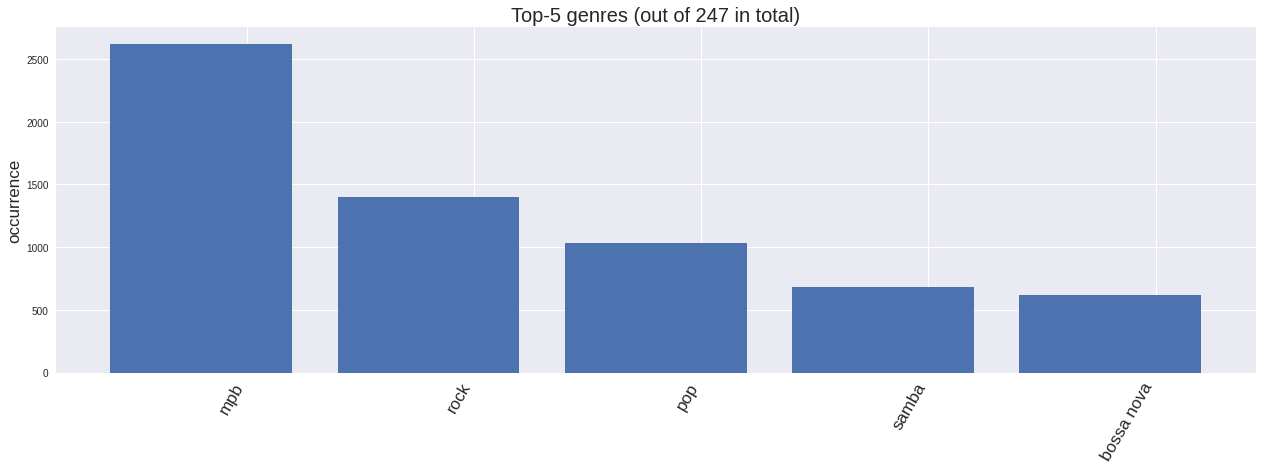

In [14]:
genre_counter_pt = analyze_genre_tag_df(df_genre_pt, top_n = 5)
plt.tight_layout()
genre_counter_pt = sorted(genre_counter_pt.items(), key=lambda item: item[1], reverse = True)
genre_counter_top_list_pt = [genre for genre, count in genre_counter_pt[:5] ]
genre_counter_top_list_pt

In [15]:
df_genre_pt = df_genre_pt[df_genre_pt['genres'].isin(genre_counter_top_list_pt)]
df_genre_pt

,id,genres,lang
56,02Fwq8lfGcaP9UMZ,samba,pt
398,0EoiY1vEVwSXLH1u,mpb,pt
414,0FK9SM3bDg5uG5x2,samba,pt
627,0MIOHtRyY6LRpleM,mpb,pt
656,0N5HaBTkWt5stsQa,samba,pt
...,...,...,...
108821,zjnYSeJ41VYcKa29,bossa nova,pt
109017,zqvmMIUrqZXFIH8u,samba,pt
109061,zsRdrEEdvOV1pvJW,samba,pt
109131,zuQuGr1ObYEQdmVu,mpb,pt


Spanish

In [16]:
#fileter Eng
df_lang = pd.read_csv(os.path.join(CSV_FOLDER, 'id_lang.csv'), header=0, sep='	')
df_lang_es=df_lang[ df_lang['lang'].isin(['es']) ]
df_lang_es

,id,lang
14,00XWljDxNBgBKEEA,es
51,023KeDV5DfyxOplZ,es
95,03ZQb2ctptlPqj4K,es
99,03ouHBQJK0nNWXUQ,es
192,07QRvQw4sk50K7ZS,es
...,...,...
109055,zsHiSjhYdEQdkRcZ,es
109137,zuoO1Uw4sHUDE1Vl,es
109163,zvpDM2CCI3BdjrKm,es
109196,zxE8Hv3rDDFdgZzu,es


In [17]:
# merge en dataframes & genres into one
df_genre_es = pd.concat([df_genres['id'], df_genres['genres'], df_lang_es['lang']]
                             , join='inner' ,axis=1)

#Do inner join
df_genre_es

,id,genres,lang
14,00XWljDxNBgBKEEA,pop,es
51,023KeDV5DfyxOplZ,"latin,world",es
95,03ZQb2ctptlPqj4K,pop,es
99,03ouHBQJK0nNWXUQ,hip hop,es
192,07QRvQw4sk50K7ZS,spanish rock,es
...,...,...,...
109055,zsHiSjhYdEQdkRcZ,rock en espanol,es
109137,zuoO1Uw4sHUDE1Vl,banda,es
109163,zvpDM2CCI3BdjrKm,"lounge,alternative rock,rock en espanol,rock,a...",es
109196,zxE8Hv3rDDFdgZzu,"latin,reggaeton",es


Number of genres: 213


['pop', 'latin', 'latin pop', 'rock', 'reggaeton']

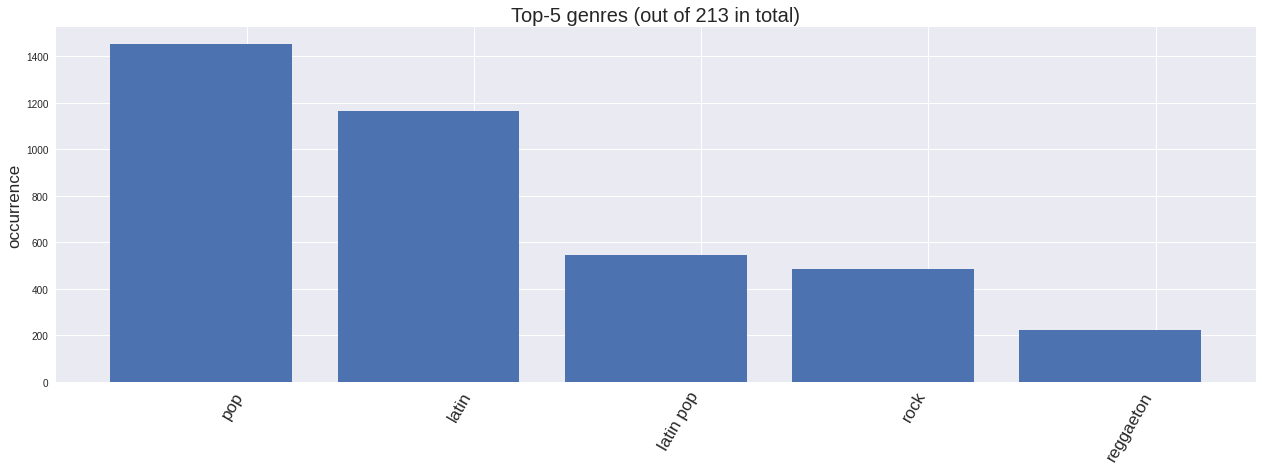

In [18]:
genre_counter_es = analyze_genre_tag_df(df_genre_es, top_n = 5)
plt.tight_layout()
genre_counter_es = sorted(genre_counter_es.items(), key=lambda item: item[1], reverse = True)
genre_counter_top_list_es = [genre for genre, count in genre_counter_es[:5] ]
genre_counter_top_list_es

In [19]:
df_genre_es = df_genre_es[df_genre_es['genres'].isin(genre_counter_top_list_es)]
df_genre_es

,id,genres,lang
14,00XWljDxNBgBKEEA,pop,es
95,03ZQb2ctptlPqj4K,pop,es
279,0AUKdqKreusplDjG,rock,es
358,0DDGPJTcQaNL45dy,latin,es
423,0FbB6l6wAEh8Enoe,latin pop,es
...,...,...,...
108561,zZpef5PJiTG9eSUW,reggaeton,es
108588,zayBcP8wuOWcxjLY,latin,es
108697,zf6I9Rp77pkBkbZE,pop,es
108740,zgUn3BX8GFAWZu9U,latin,es


Get conbined dataframe for clf1

In [20]:
df_genre_en_pt_es = pd.concat([df_genre_en, df_genre_pt, df_genre_es], ignore_index=True)
df_genre_en_pt_es

,id,genres,lang
0,0009fFIM1eYThaPg,pop,en
1,00b6fV3nx5z2b8Ls,pop,en
2,013QDoTqbexEwkHr,pop,en
3,01EKNot8qVgZpKM7,rock,en
4,01I5p010ajulr0O5,pop,en
...,...,...,...
10905,zZpef5PJiTG9eSUW,reggaeton,es
10906,zayBcP8wuOWcxjLY,latin,es
10907,zf6I9Rp77pkBkbZE,pop,es
10908,zgUn3BX8GFAWZu9U,latin,es


### Get lyrics document as dataframe and append to X_train, X_test

In [21]:
#create lyric column
df_genre_en_pt_es["lyric"] = ""
df_genre_en_pt_es

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,
1,00b6fV3nx5z2b8Ls,pop,en,
2,013QDoTqbexEwkHr,pop,en,
3,01EKNot8qVgZpKM7,rock,en,
4,01I5p010ajulr0O5,pop,en,
...,...,...,...,...
10905,zZpef5PJiTG9eSUW,reggaeton,es,
10906,zayBcP8wuOWcxjLY,latin,es,
10907,zf6I9Rp77pkBkbZE,pop,es,
10908,zgUn3BX8GFAWZu9U,latin,es,


In [23]:
#create temporary lyric folder on google collab
# do not read texts from google drive. it is slow.
ZIP_FILE ="drive/MyDrive/music4all/lyrics.zip"

!unzip drive/MyDrive/music4all/lyrics.zip -d /content/

Archive:  drive/MyDrive/music4all/lyrics.zip
replace /content/lyrics/0009fFIM1eYThaPg.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
N


In [22]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

In [23]:
#First 5000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_en_pt_es.loc[0:5000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]

      df_genre_en_pt_es.loc[df_genre_en_pt_es.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [24]:
#index 5001 ~ 10,000
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_en_pt_es.loc[5001:10000].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      #Stemming and normalization
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]
      #print(lyric_document)

      df_genre_en_pt_es.loc[df_genre_en_pt_es.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [25]:
#index 10001 ~ 14696
LYRICS_FOLDER ="lyrics/"
lyric_dict={}

for idx, row in df_genre_en_pt_es.loc[10001:df_genre_en_pt_es.shape[0]].iterrows():
  #print(row['id'])
  filename=LYRICS_FOLDER+row['id']+".txt"
  try:
    with open(filename, 'r') as file:
      lyric_document = file.read().replace('\n', ' ')
      lyric_document=[' '.join([stemmer.stem(word.lower()) for word in lyric_document.split(' ')]) ]
      
      df_genre_en_pt_es.loc[df_genre_en_pt_es.id == row['id'], "lyric"] = lyric_document
      #print(lyric_document)

  except Exception as e:
    print(e)


In [26]:
df_genre_en_pt_es[0:14696]

,id,genres,lang,lyric
0,0009fFIM1eYThaPg,pop,en,"it' a sunni day, so i got nowher to hide not a..."
1,00b6fV3nx5z2b8Ls,pop,en,a buh-buh buh buh-buh a buh-buh buh buh-buh y...
2,013QDoTqbexEwkHr,pop,en,"it' like a conversation, where no-on stop to b..."
3,01EKNot8qVgZpKM7,rock,en,say the word i cannot say say them on anoth da...
4,01I5p010ajulr0O5,pop,en,i wa alon i wa made of stone you took me home ...
...,...,...,...,...
10905,zZpef5PJiTG9eSUW,reggaeton,es,for the world el duo dinamico w con yandel! a...
10906,zayBcP8wuOWcxjLY,latin,es,"girl al salto, pura, papayo, mr. worldwide, da..."
10907,zf6I9Rp77pkBkbZE,pop,es,"sin ti no soy nada, una gota de lluvia mojando..."
10908,zgUn3BX8GFAWZu9U,latin,es,papi no me llore lagrimita que me siento una c...


Note: for En,Es,Pt dataframe, we will copy them after split is done, because we want to use same test set for clfs as well.


### KfoldSplit

In [27]:
def StratifiedKFold_feature_and_df(df, y_name):
  skf = StratifiedKFold(n_splits=5)  # 20% for test set 
  # In the above code, I removed from random_state=1209 due to an error message
  y = df[y_name]
  skf.get_n_splits(df[['id', 'lyric', 'lang']], y)

  splits = []

  for train_index, test_index in skf.split(df[['id', 'lyric']], y):
      print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = df[['id', 'lyric', 'lang']].loc[train_index], df[['id', 'lyric', 'lang']].loc[test_index]
      y_train, y_test = y.loc[train_index], y.loc[test_index]
      splits.append({'X_train': X_train, 'X_test': X_test, 'y_train':y_train, 'y_test':y_test })
  return splits

In [28]:
splits = StratifiedKFold_feature_and_df( df_genre_en_pt_es, 'genres')

TRAIN: [ 1629  1663  1708 ... 10907 10908 10909] TEST: [    0     1     2 ... 10459 10463 10465]
TRAIN: [    0     1     2 ... 10907 10908 10909] TEST: [ 1629  1663  1708 ... 10564 10567 10572]
TRAIN: [    0     1     2 ... 10907 10908 10909] TEST: [ 3570  3573  3649 ... 10665 10666 10670]
TRAIN: [    0     1     2 ... 10907 10908 10909] TEST: [ 5345  5368  5385 ... 10766 10788 10800]
TRAIN: [    0     1     2 ... 10766 10788 10800] TEST: [ 7075  7101  7116 ... 10907 10908 10909]


In [29]:
split0=splits[0]
print(split0['X_train'].shape)
print(split0['y_train'].shape)

(8728, 3)
(8728,)


### Step3 Create X_train_en/es/pt from X_train, repeat for y_train_en/es/pt

In [30]:
split0['X_train']["lang"]

1629     en
1663     en
1708     en
1714     en
1741     en
         ..
10905    es
10906    es
10907    es
10908    es
10909    es
Name: lang, Length: 8728, dtype: object

In [31]:
X_train_en  = split0['X_train'][ split0['X_train']["lang"] == "en" ]
X_train_pt  = split0['X_train'][ split0['X_train']["lang"] == "pt" ]
X_train_es  = split0['X_train'][ split0['X_train']["lang"] == "es" ]

In [32]:
X_train_en.index

Int64Index([1629, 1663, 1708, 1714, 1741, 1749, 1754, 1786, 1802, 1808,
            ...
            8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999],
           dtype='int64', length=7056)

In [33]:
y_train_en = split0['y_train'][split0['y_train'].index.isin( X_train_en.index) ]
y_train_pt = split0['y_train'][split0['y_train'].index.isin( X_train_pt.index) ]
y_train_es = split0['y_train'][split0['y_train'].index.isin( X_train_es.index) ]

In [34]:
X_test_en = split0['X_test'][split0['X_test']["lang"] == "en"]
X_test_pt = split0['X_test'][split0['X_test']["lang"] == "pt"]
X_test_es = split0['X_test'][split0['X_test']["lang"] == "es"]

In [48]:
y_test_en = split0['y_test'][split0['y_test'].index.isin( X_test_en.index) ]
y_test_pt = split0['y_test'][split0['y_test'].index.isin( X_test_pt.index) ]
y_test_es = split0['y_test'][split0['y_test'].index.isin( X_test_es.index) ]

In [35]:
X_test_es

,id,lyric,lang
10350,0DDGPJTcQaNL45dy,"ere lo que má quiero en est mundo, eso ere mi ...",es
10351,0FbB6l6wAEh8Enoe,tien que bailarlo natur pued ir bailándolo hac...,es
10352,0JYtXY3CuqIzHvfy,si miro al cielo siempr encuentro consuelo por...,es
10353,0RKIUAOJaWQNCWyz,cada día es igual por mi pasillo nunca llego a...,es
10357,1AqpsTHvfqi7CWtW,sentí que ya te conocía y me entregu todo tu c...,es
10358,1J6y12wluBzEUtiJ,"bonito, todo me parec bonito bonita mañana, bo...",es
10360,1Ro6zcwKhJC8ISwi,yo soy reykon el líder i-i-i-icon rudeboyz pa...,es
10363,1dFFzY3N5N4wZetJ,"kenedi si necesita' reggaetón, dale sigu bail...",es
10364,1gI7efcSkZQAydia,hace día perdí en alguna cantina la mitad de m...,es
10366,1jkzzxdtdUcstunm,siempr será la niña que me llena el alma como ...,es


In [49]:
y_test_en

0        pop
1        pop
2        pop
3       rock
4        pop
        ... 
2078    rock
2081    rock
2090    rock
2093    rock
2099    rock
Name: genres, Length: 1944, dtype: object

### Step4: fit and transform, predict for clf1

In [36]:
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf = tfidf_vectorizer.fit_transform(split0['X_train']['lyric']).toarray()
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [37]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train_tfidf, split0['y_train']) 
print(sorted(Counter(y_resampled).items()))

[('alternative rock', 4504), ('bossa nova', 4504), ('electronic', 4504), ('indie rock', 4504), ('latin', 4504), ('latin pop', 4504), ('mpb', 4504), ('pop', 4504), ('reggaeton', 4504), ('rock', 4504), ('samba', 4504)]


In [38]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn import metrics
#Step4: Create MultinomialNB classifier and fit()
#Use X_resampled, y_resampled
clf_mnb = MultinomialNB().fit(X_resampled, y_resampled)

In [39]:
X_test_tfidf = tfidf_vectorizer.transform(split0['X_test']['lyric']).toarray()

In [40]:
print("Train/Test Vector Size : ", X_resampled.shape, X_test_tfidf.shape)

Train/Test Vector Size :  (49544, 35842) (2182, 35842)


In [43]:
predicted_mnb_SMOTE = clf_mnb.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_mnb_SMOTE) )

                  precision    recall  f1-score   support

alternative rock       0.06      0.33      0.11        67
      bossa nova       0.31      0.25      0.28        16
      electronic       0.16      0.27      0.20       190
      indie rock       0.20      0.52      0.29       217
           latin       0.72      0.50      0.59        26
       latin pop       0.33      0.50      0.40        12
             mpb       0.82      0.89      0.85       141
             pop       0.81      0.50      0.62      1127
       reggaeton       0.50      0.64      0.56        14
            rock       0.40      0.03      0.05       343
           samba       0.43      0.31      0.36        29

        accuracy                           0.42      2182
       macro avg       0.43      0.43      0.39      2182
    weighted avg       0.59      0.42      0.45      2182



In [45]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_mnb_SMOTE)

0.4300416944331104

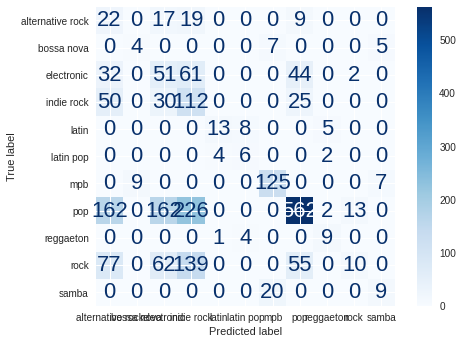

<Figure size 720x720 with 0 Axes>

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_mnb_SMOTE
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

All language , but this time use SVM

In [41]:
from sklearn import svm
clf_svm_SMOTE = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_SMOTE.fit(X_resampled, y_resampled)

SVC(gamma='auto', kernel='linear')

Took 1 Hour and 45 min

In [42]:
#predicted_mnb_SMOTE = clf_mnb.predict(X_test_tfidf)
predicted_svm_SMOTE = clf_svm_SMOTE.predict(X_test_tfidf)
print(metrics.classification_report(split0['y_test'], predicted_svm_SMOTE) )

                  precision    recall  f1-score   support

alternative rock       0.13      0.19      0.15        67
      bossa nova       0.38      0.19      0.25        16
      electronic       0.18      0.31      0.23       190
      indie rock       0.19      0.25      0.22       217
           latin       0.60      0.35      0.44        26
       latin pop       0.33      0.17      0.22        12
             mpb       0.80      0.77      0.79       141
             pop       0.75      0.60      0.67      1127
       reggaeton       0.75      0.43      0.55        14
            rock       0.23      0.24      0.24       343
           samba       0.60      0.31      0.41        29

        accuracy                           0.47      2182
       macro avg       0.45      0.35      0.38      2182
    weighted avg       0.54      0.47      0.50      2182



Took 11 min.

In [43]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(split0['y_test'], predicted_svm_SMOTE)

0.3467447907575799

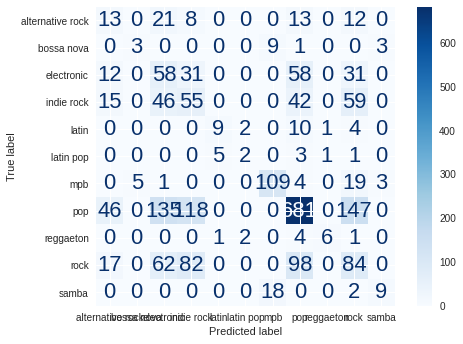

<Figure size 720x720 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(split0['y_test'], predicted_svm_SMOTE
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

### English classifier

In [45]:
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_en = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf_en = tfidf_vectorizer_en.fit_transform(X_train_en['lyric']).toarray()
X_train_tfidf_en

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
from imblearn.over_sampling import SMOTE
X_resampled_en, y_resampled_en = SMOTE().fit_resample(X_train_tfidf_en, y_train_en)#split0['y_train'] 
print(sorted(Counter(y_resampled_en).items()))

[('alternative rock', 4052), ('electronic', 4052), ('indie rock', 4052), ('pop', 4052), ('rock', 4052)]


In [51]:
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn import metrics
#Step4: Create MultinomialNB classifier and fit()
#Use X_resampled, y_resampled
clf_mnb_en = MultinomialNB().fit(X_resampled_en, y_resampled_en)
X_test_tfidf_en = tfidf_vectorizer_en.transform( X_test_en['lyric'] ).toarray() #split0['X_test']['lyric']

predicted_mnb_en_SMOTE = clf_mnb_en.predict(X_test_tfidf_en)
print(metrics.classification_report(y_test_en, predicted_mnb_en_SMOTE) )

                  precision    recall  f1-score   support

alternative rock       0.07      0.18      0.10        67
      electronic       0.20      0.15      0.17       190
      indie rock       0.25      0.28      0.27       217
             pop       0.76      0.66      0.71      1127
            rock       0.26      0.31      0.28       343

        accuracy                           0.49      1944
       macro avg       0.31      0.32      0.30      1944
    weighted avg       0.54      0.49      0.51      1944



In [52]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_en, predicted_mnb_en_SMOTE)

0.31558346707707263

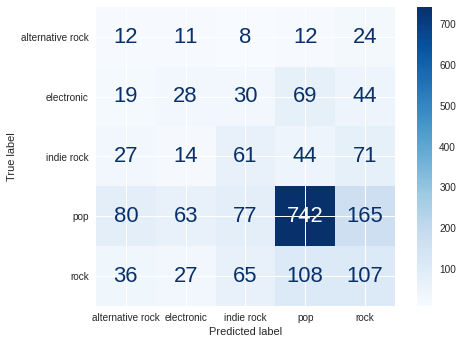

<Figure size 720x720 with 0 Axes>

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_en, predicted_mnb_en_SMOTE
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

English SVM

In [54]:
from sklearn import svm
clf_svm_SMOTE_en = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_SMOTE_en.fit(X_resampled_en, y_resampled_en)

SVC(gamma='auto', kernel='linear')

In [55]:
#predicted_mnb_SMOTE = clf_mnb.predict(X_test_tfidf)
predicted_svm_SMOTE_en = clf_svm_SMOTE_en.predict(X_test_tfidf_en)
print(metrics.classification_report(y_test_en, predicted_svm_SMOTE_en) )

                  precision    recall  f1-score   support

alternative rock       0.12      0.19      0.15        67
      electronic       0.17      0.28      0.21       190
      indie rock       0.21      0.27      0.23       217
             pop       0.77      0.61      0.68      1127
            rock       0.27      0.27      0.27       343

        accuracy                           0.47      1944
       macro avg       0.31      0.33      0.31      1944
    weighted avg       0.54      0.47      0.50      1944



In [56]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_en, predicted_svm_SMOTE_en)

0.325958143739482

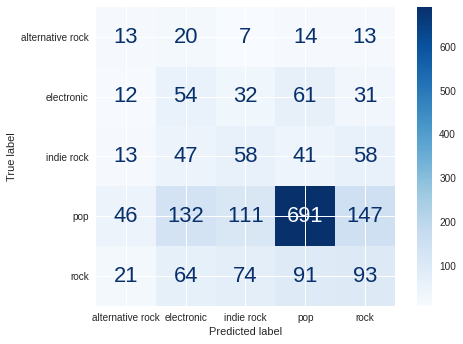

<Figure size 720x720 with 0 Axes>

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test_en, predicted_svm_SMOTE_en
                                        , cmap=plt.cm.Blues)
plt.figure(figsize=(10, 10))
plt.show()

### Portuguese classifier

In [58]:
from sklearn.metrics import accuracy_score,hamming_loss,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_pt = TfidfVectorizer(analyzer="word", stop_words='english')

X_train_tfidf_pt = tfidf_vectorizer_pt.fit_transform(X_train_pt['lyric']).toarray()
X_train_tfidf_pt

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11454238,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [59]:
from imblearn.over_sampling import SMOTE
X_resampled_pt, y_resampled_pt = SMOTE().fit_resample(X_train_tfidf_pt, y_train_pt)#split0['y_train'] 
print(sorted(Counter(y_resampled_pt).items()))

[('bossa nova', 567), ('mpb', 567), ('pop', 567), ('rock', 567), ('samba', 567)]


In [61]:
X_test_tfidf_pt = tfidf_vectorizer_pt.transform( X_test_pt['lyric'] ).toarray()

Pt -SVM

In [60]:
from sklearn import svm
clf_svm_SMOTE_pt = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
clf_svm_SMOTE_pt.fit(X_resampled_pt, y_resampled_pt)

SVC(gamma='auto', kernel='linear')

In [62]:
predicted_svm_SMOTE_pt = clf_svm_SMOTE_pt.predict(X_test_tfidf_pt)
print(metrics.classification_report(y_test_pt, predicted_svm_SMOTE_pt) )

              precision    recall  f1-score   support

  bossa nova       0.25      0.12      0.17        16
         mpb       0.77      0.73      0.75       141
         pop       0.00      0.00      0.00         0
        rock       0.00      0.00      0.00         0
       samba       0.64      0.24      0.35        29

    accuracy                           0.60       186
   macro avg       0.33      0.22      0.25       186
weighted avg       0.70      0.60      0.64       186



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
predicted_svm_SMOTE_pt

array(['mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'samba', 'mpb', 'mpb', 'mpb',
       'mpb', 'mpb', 'samba', 'bossa nova', 'mpb', 'mpb', 'rock', 'mpb',
       'mpb', 'samba', 'mpb', 'mpb', 'mpb', 'mpb', 'pop', 'mpb', 'mpb',
       'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'pop',
       'mpb', 'rock', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb', 'mpb',
       'mpb', 'mpb', 'mpb', 'mpb', 'pop', 'mpb', 'rock', 'mpb', 'mpb',
       'mpb', 'mpb', 'samba', 'mpb', 'mpb', 'rock', 'mpb', 'pop', 'mpb',
       'bossa nova', 'bossa nova', 'mpb', 'rock', 'mpb', 'mpb', 'mpb',
       'mpb', 'mpb', 'pop', 'mpb', 'mpb', 'bossa nova', 'mpb', 'mpb',
       'mpb', 'mpb', 'rock', 'mpb', 'mpb', 'mpb', 'mpb', 'pop', 'mpb',
       'rock', 'mpb', 'mpb', 'pop', 'mpb', 'mpb', 'mpb', 'mpb', 'rock',
       'mpb', 'pop', 'pop', 'pop', 'mpb', 'mpb', 'mpb', 'mpb', 'samba',
       'mpb', 'mpb', 'samba', 'mpb', 'mpb', 'rock', 'mpb', 'mpb', 'mpb',
       'mpb', 'mpb', 'mpb', 'mpb', 'pop', 'mpb', 'mpb', 'mpb', 'mpb',

In [63]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_pt, predicted_svm_SMOTE_pt)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.3656252547485123